In [1]:
import csv
import shutil
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2

**DOWNLOAD COUGHVID DATASET**








In [2]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
# https://zenodo.org/record/4048312/files/public_dataset.zip?download=1 (older version of ds)
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip


--2022-05-26 14:06:57--  https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>]   1.24G  14.9MB/s    in 3m 39s  

2022-05-26 14:10:38 (5.80 MB/s) - ‘public_dataset.zip?download=1’ saved [1332806163/1332806163]



In [3]:
c=0
j=0
o=0
for file in os.listdir('public_dataset'):
    if file.endswith(".webm") :
        c+=1
        
    if file.endswith(".json") :
       j+=1
    if file.endswith(".ogg") :
       o+=1
print("no of .webm files  " +str(c))
print("no of .json files  "+str(j))
print("no of .ogg files   "+str(o))

no of .webm files  25985
no of .json files  27550
no of .ogg files   1565



**SELECT COVID SAMPLES FROM COUGHVID DATASET**


In [5]:
count=0
webm_count=0
covid_samples_count=0
reduced=0
bad=0

selected_filenames=[]
coughvid_webm_files=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        count+=1
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='COVID-19'):
                    covid_samples_count+=1

                    if 'expert_labels_1' in data:
                        if(data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_2' in data:
                        if(data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_3' in data:
                        if(data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    else:
                        reduced+=1
                        selected_filenames.append(path)
        if file.endswith(".webm") :
           coughvid_webm_files.append(file)


In [6]:
#print(selected_filenames)
print(len(selected_filenames))

438


In [7]:
print("Total Number of samples :",count)
print("\nTotal Number of COVID-19 samples with cough_detected score>0.9 :",covid_samples_count)
print("\nExpert labeled COVID-19 samples with quality good/ok OR not expert labelled :",reduced)

Total Number of samples : 27550

Total Number of COVID-19 samples with cough_detected score>0.9 : 499

Expert labeled COVID-19 samples with quality good/ok OR not expert labelled : 438


SAVE +VE SAMPLES

In [8]:
coughvid  = '/content/public_dataset/'
VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

coughvid_positive = VidData.loc[VidData['status']=='COVID-19']
'''coughvid_negative = VidData.loc[VidData['status']!='COVID-19'] [0:1200]
'''
coughvid_positive['DIR'] = coughvid + coughvid_positive['uuid'] + '.webm'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [9]:
coughvid_positive.head()

,uuid,fever_muscle_pain,respiratory_condition,status,DIR
140,015576c8-2b03-4dcb-b251-78a984fe86fe,False,False,COVID-19,/content/public_dataset/015576c8-2b03-4dcb-b25...
155,0177b817-0ba3-498a-bc05-48bc66cc91b8,False,False,COVID-19,/content/public_dataset/0177b817-0ba3-498a-bc0...
158,01820f7c-b953-4faf-aa13-978cfda6b08e,False,False,COVID-19,/content/public_dataset/01820f7c-b953-4faf-aa1...
177,01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7,False,False,COVID-19,/content/public_dataset/01bf156f-a8ff-48f6-933...
272,02aa80ef-a83b-477f-b01d-575651364b22,True,False,COVID-19,/content/public_dataset/02aa80ef-a83b-477f-b01...


In [10]:
!mkdir coughvidpos

In [11]:
for i in coughvid_positive ['DIR']:
  name=os.path.splitext(i)[0]
  if os.path.exists(name+'.webm'):
    filepath=name+'.webm'
    shutil.copy(filepath,'/content/coughvidpos')
  else:   
    filepath=name+'.ogg'
    shutil.copy(filepath,'/content/coughvidpos')


In [12]:
len([file for file in os.listdir('/content/coughvidpos')])

699

SELECT HEALTHY SAMPLES FROM COUGHVID DATASET


In [13]:
!mkdir coughvidnegative

In [46]:
healthy_samples=0
reduced=0
paths=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='healthy'):
                    healthy_samples+=1

                    if 'expert_labels_1' in data:
                        if((data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_2' in data:
                        if((data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_3' in data:
                        if((data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    else:
                        reduced+=1
                        paths.append(path)
                        
    if reduced==1387:
        break

In [47]:
print("Number of healthy cough sound samples considered : ",reduced)

Number of healthy cough sound samples considered :  1387


In [48]:

cougvidnegative = '/content/coughvidnegative'
for i in paths:
    name=os.path.splitext(i)[0]
    if os.path.exists(name+'.webm'):
      filepath=name+'.webm'
      shutil.copy(filepath,cougvidnegative)
    else:   
     filepath=name+'.ogg'
     shutil.move(filepath,cougvidnegative)


In [49]:

len([file for file in os.listdir('/content/coughvidnegative')])
 

1387

In [16]:
!mkdir val train test
!mkdir COVID HEALTHY
!mkdir val/COVID 
!mkdir val/HEALTHY
!mkdir test/COVID 
!mkdir test/HEALTHY
!mkdir train/COVID 
!mkdir train/HEALTHY

In [ ]:
import soundfile as sf
for filename in os.listdir('/content/coughvidpos'):
        samples, sr= librosa.load('/content/coughvidpos/'+filename, sr=22050)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/COVID/'+audio_file+'.wav',samples,sr)
 

In [18]:
len([file for file in os.listdir('COVID')])

699

In [50]:
for filename in tqdm(os.listdir('/content/coughvidnegative')):
        samples, sr = librosa.load('/content/coughvidnegative/'+filename, sr=sr)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/HEALTHY/'+audio_file+'.wav',samples,sr)

  0%|          | 0/1387 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/1387 [00:01<40:44,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/1387 [00:02<26:50,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/1387 [00:02<18:13,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/1387 [00:03<16:13,  1.42it/s]/usr/loc

In [51]:
len([file for file in os.listdir('HEALTHY')])

1387

**COUGHVID DATA AUGMENTATION**

In [ ]:
!pip install audiomentations

In [20]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf

In [21]:
!mkdir augmented_covid_data

In [22]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COVID'
augmented_data= '/content/augmented_covid_data'
for audio_file in tqdm(os.listdir(sets)):
        samples, sr = librosa.load(sets+'/'+audio_file)
        augmented_sample = augment(samples=samples, sample_rate=sr)
        sf.write(augmented_data+'/aug_'+audio_file, augmented_sample, sr)

100%|██████████| 699/699 [02:34<00:00,  4.52it/s]


In [23]:
#number of  augmented covid samples
len([file for file in os.listdir('/content/augmented_covid_data')])

699

**COSWARA DATASET**


In [24]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 41.91 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

In [53]:
healthy_count=0
covid_pos_count=0
with open('/content/Coswara-Data/combined_data.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        COVID_STATUS=row[2]
        if(COVID_STATUS=='healthy' or COVID_STATUS=='resp_illness_not_identified' or COVID_STATUS=='no_resp_illness_exposed' or COVID_STATUS== 'recovered_full'):
            healthy_count+=1
        elif(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
            covid_pos_count+=1
    
print("Healthy => ",healthy_count," Covid => ",covid_pos_count)

Healthy =>  1984  Covid =>  681


In [27]:
from operator import length_hint
names   = ['ID','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')
  temp        = temp[['id','covid_status','DIR']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:24<00:00, 113.98it/s]


,ID,STATUS,DIR,DataSet
0,48PWPg1zZZS9UbuHspwNMsiOfep1,healthy,/content/Coswara-Data/20200525/48PWPg1zZZS9Ubu...,coswara
0,BAMibuHkXaNr3JNc0Cvbu3kdSIp1,healthy,/content/Coswara-Data/20200525/BAMibuHkXaNr3JN...,coswara
0,zzh7tK9CrZacOddJTG9YQwCZz4f2,healthy,/content/Coswara-Data/20200525/zzh7tK9CrZacOdd...,coswara
0,t0UxwxXhJxX6jA1bJNTQYjOWeQj1,healthy,/content/Coswara-Data/20200525/t0UxwxXhJxX6jA1...,coswara
0,9zO8MvWYvBMLy2y2rRFKRHb9A1r1,healthy,/content/Coswara-Data/20200525/9zO8MvWYvBMLy2y...,coswara


In [28]:
CosData1['STATUS'].unique()

array(['healthy', 'resp_illness_not_identified', 'positive_mild',
       'no_resp_illness_exposed', 'recovered_full', 'positive_asymp',
       'positive_moderate', 'under_validation'], dtype=object)

In [29]:
!mkdir coswara_COVID

In [30]:
for index, row in CosData1.iterrows():
  COVID_STATUS=row[1]  
  if(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
     try:
      shutil.copy(row[2],'/content/coswara_COVID/'+row[0]+'-s-'+'.wav')
      
     except:
      
        print("file not found")

In [35]:
#this a stupid way to resample, fixing it later
!mkdir COSWARA_COVID_SAMPLES
for filename in os.listdir('/content/coswara_COVID'):
   try:
        samples, sr = librosa.load('/content/coswara_COVID/'+filename, sr=sr)
        sf.write ('/content/COSWARA_COVID_SAMPLES/'+filename,samples,sr)
   except:
    print("file too small")

file too small
file too small
file too small


In [36]:
len([file for file in os.listdir('/content/COSWARA_COVID_SAMPLES/')])

678

In [ ]:

for i in os.listdir('/content/COSWARA_COVID_SAMPLES'):
  print( librosa.get_samplerate('/content/COSWARA_COVID_SAMPLES/' +i))

In [54]:
!mkdir coswara_HEALTHY
c=0
for index, row in CosData1.iterrows():
  COVID_STATUS=row[1]  
  if(COVID_STATUS=='healthy'):
     try:
      shutil.copy(row[2],'/content/coswara_HEALTHY/'+row[0]+'-s-'+'.wav')
      c=c+1
      if c==1387:
        break
     except:
      
        print("file not found")

In [55]:
c=0
for i in os.listdir('/content/coswara_HEALTHY/'):
  c=c+1
c

1387

In [56]:
#this a stupid way to resample, fixing it later
!mkdir COSWARA_HEALTHY_SAMPLES
for filename in os.listdir('/content/coswara_HEALTHY'):
   try:
        samples, sr = librosa.load('/content/coswara_HEALTHY/'+filename, sr=sr)
        sf.write ('/content/COSWARA_HEALTHY_SAMPLES/'+filename,samples,sr)
   except:
    print("file too small")
shutil.rmtree('/content/coswara_HEALTHY')

file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small


In [57]:
for file in os.listdir('/content/COSWARA_HEALTHY_SAMPLES'):
    shutil.move('/content/COSWARA_HEALTHY_SAMPLES/'+ file, '/content/HEALTHY/')

**COSWARA DATA AUGMENTATION**

In [37]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COSWARA_COVID_SAMPLES'
for audio_file in tqdm(os.listdir(sets)):
  try:
     samples, sr = librosa.load(sets+'/'+audio_file)
     augmented_sample = augment(samples=samples, sample_rate=sr)
     sf.write('/content/augmented_covid_data'+'/coswara_aug_'+audio_file, augmented_sample, sr)

  except:
    print("\n File can't open")

100%|██████████| 678/678 [01:30<00:00,  7.52it/s]


In [38]:
len([file for file in os.listdir('/content/augmented_covid_data')])

1377

**move coswara covid files to COVID directory** 

In [41]:
for file in tqdm(os.listdir('/content/COSWARA_COVID_SAMPLES')):
    shutil.copy('/content/COSWARA_COVID_SAMPLES/'+ file, '/content/COVID/')

100%|██████████| 678/678 [00:00<00:00, 927.01it/s]


In [42]:
for file in tqdm(os.listdir('/content/augmented_covid_data')):
    shutil.copy('/content/augmented_covid_data/'+ file, '/content/COVID/')

100%|██████████| 1377/1377 [00:05<00:00, 255.28it/s]


In [43]:
len([file for file in os.listdir('/content/COVID')])

2754

In [62]:
len([file for file in os.listdir('HEALTHY')])

2744

**SPLIT 80 , 20  for train, test**

In [70]:
num=0
for file in os.listdir('COVID'):
    num+=1
    if num<=551:
        shutil.copy('/content/COVID/'+file,'/content/test/COVID/'+file)
    else:
        shutil.copy('/content/COVID/'+file,'/content/train/COVID/'+file)
        


In [71]:
num=0
for file in os.listdir('HEALTHY'):
    num+=1
    if num<= 549:
        shutil.copy('/content/HEALTHY/'+file,'/content/test/HEALTHY/'+file)
    else:
        shutil.copy('/content/HEALTHY/'+file,'/content/train/HEALTHY/'+file)

In [72]:

print(" train/COVID =>",len([file for file in os.listdir('train/COVID')]))
print(" test/COVID =>",len([file for file in os.listdir('test/COVID')]))


print(" train/healthy =>",len([file for file in os.listdir('train/HEALTHY')]))
print(" test/healthy =>",len([file for file in os.listdir('test/HEALTHY')]))


 train/COVID => 2203
 test/COVID => 551
 train/healthy => 2195
 test/healthy => 549


In [73]:
!pip install pyAudioAnalysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.3 MB 1.3 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=bc4c25d83ab7e91a8ea98c3a92086b89a6774bb52fd47f76d677c3f60b6404cb
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [ ]:
!pip install eyed3

In [75]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
from pyAudioAnalysis import audioTrainTest as aT

##KNN

In [77]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "knn", "knn_model", use_smote=True)

Analyzing file 1 of 2203: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 2203: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 2203: train/COVID/0177b817-0ba3-498a-bc05-48bc66cc91b8.wav
Analyzing file 4 of 2203: train/COVID/02aa80ef-a83b-477f-b01d-575651364b22.wav
Analyzing file 5 of 2203: train/COVID/031fd54a-87b5-4223-9af6-60985127fb7a.wav
Analyzing file 6 of 2203: train/COVID/033da4e3-7365-4adc-9252-7347816e4e77.wav
Analyzing file 7 of 2203: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 8 of 2203: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 9 of 2203: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 10 of 2203: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 11 of 2203: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 12 of 2203: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 13 of 2203: train/COVID/082991fb-ee66-4970-9

In [80]:
import plotly
import plotly.subplots
import seaborn as sn
import matplotlib.pyplot as plt

[[317 234]
 [122 427]]
[0.5753176043557169, 0.7777777777777778] [0.7220956719817767, 0.6459909228441755] [0.6404040404040404, 0.7057851239669422] 0.6730945821854912 0.6763636363636364


Text(60.0, 0.5, 'Truth value')

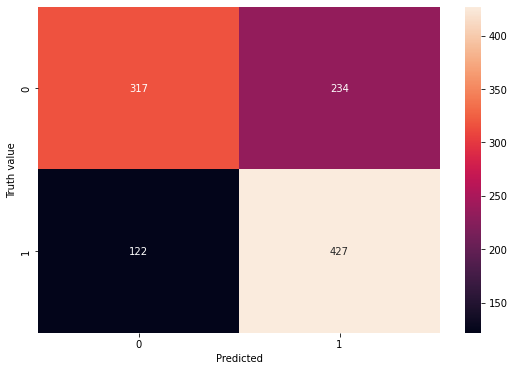

In [81]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "knn_model", "knn","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [82]:
acc=(317+427)/(122+317+234+427)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 67.64


##GRADIENT_BOOSTING

In [83]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "gradientboosting", "gradientboosting_model", use_smote=True)

Analyzing file 1 of 2203: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 2203: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 2203: train/COVID/0177b817-0ba3-498a-bc05-48bc66cc91b8.wav
Analyzing file 4 of 2203: train/COVID/02aa80ef-a83b-477f-b01d-575651364b22.wav
Analyzing file 5 of 2203: train/COVID/031fd54a-87b5-4223-9af6-60985127fb7a.wav
Analyzing file 6 of 2203: train/COVID/033da4e3-7365-4adc-9252-7347816e4e77.wav
Analyzing file 7 of 2203: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 8 of 2203: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 9 of 2203: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 10 of 2203: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 11 of 2203: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 12 of 2203: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 13 of 2203: train/COVID/082991fb-ee66-4970-9

In [86]:
import plotly
import plotly.subplots
from pyAudioAnalysis import audioTrainTest as aT
g_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "gradientboosting_model", "gradientboosting","COVID")

[[366 185]
 [ 90 459]]
[0.6642468239564429, 0.8360655737704918] [0.8026315789473685, 0.7127329192546584] [0.7269116186693149, 0.7694886839899414] 0.7482001513296281 0.75


Text(60.0, 0.5, 'Truth value')

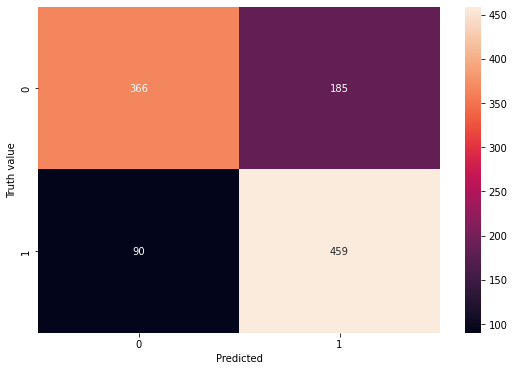

In [87]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
sn.heatmap(g_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [89]:
acc=(366+459)/(300+459+90+185)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 79.79


##RF

In [90]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "randomforest", "randomforest_model", False, use_smote=True)

Analyzing file 1 of 2203: train/COVID/00xKcQMmcAhX8CODgBBLOe7Dm0T2-s-.wav
Analyzing file 2 of 2203: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 2203: train/COVID/0177b817-0ba3-498a-bc05-48bc66cc91b8.wav
Analyzing file 4 of 2203: train/COVID/02aa80ef-a83b-477f-b01d-575651364b22.wav
Analyzing file 5 of 2203: train/COVID/031fd54a-87b5-4223-9af6-60985127fb7a.wav
Analyzing file 6 of 2203: train/COVID/033da4e3-7365-4adc-9252-7347816e4e77.wav
Analyzing file 7 of 2203: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 8 of 2203: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 9 of 2203: train/COVID/05acPS4aRGfvuOfku11Za8zve8i2-s-.wav
Analyzing file 10 of 2203: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 11 of 2203: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 12 of 2203: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 13 of 2203: train/COVID/082991fb-ee66-4970-9

[[366 185]
 [ 87 462]]
[0.6642468239564429, 0.8415300546448088] [0.8079470198675497, 0.714064914992272] [0.7290836653386454, 0.7725752508361203] 0.7508294580873829 0.7527272727272727


Text(60.0, 0.5, 'Truth value')

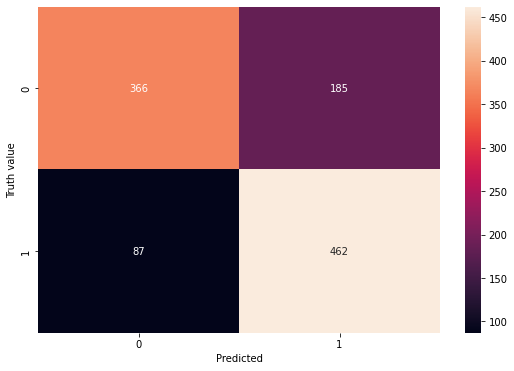

In [91]:
r_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "randomforest_model", "randomforest","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(r_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [92]:
acc=(366+462)/(362+185+87+462)

print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 75.55
